# Inventory Monitoring at Distribution Centers
In this notebook, AWS SageMaker services are used to fetch data from a database, preprocess it, and then train a machine learning model for counting the number of objects in bins.

In [1]:
# TODO: Install any packages that you might need
%%capture
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

UsageError: Line magic function `%%capture` not found.


In [23]:
!pip install smdebug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.3/83.3 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 42.5 MB/s eta 0:00:00
  Created wheel for pyinstrument-cext: filename=pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl size=6295 sha256=f2e2c9eff9c9c016df3828ff0e15eacb54348fe13f0f72e3f1d4538d410a7bfb
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0f/8b/7a/5f7fd1dd6d3cbb3d350d4c832c5e2f962687749f6d67d573a6
Successfully built pyinstrument-cext
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.4
    Uninstalling protobuf-4.24.4:
      Successfully uninstalled protobuf-4.24.4


In [25]:
!pip install --force-reinstall protobuf==3.20.*

  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [7]:
!pip install split-folders

In [1]:
# TODO: Import any packages that you might need
import os
import boto3
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs, ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
print(f'Execition Role: {role}')
print(f'Default s3 bucket : {bucket}')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Execition Role: arn:aws:iam::063864077654:role/service-role/AmazonSageMaker-ExecutionRole-20231209T204221
Default s3 bucket : sagemaker-us-east-1-063864077654


## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [6]:
import os
import json
import boto3
from tqdm import tqdm 

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

100%|██████████| 1228/1228 [01:51<00:00, 10.99it/s]


100%|██████████| 2299/2299 [03:34<00:00, 10.70it/s]


100%|██████████| 2666/2666 [04:10<00:00, 10.66it/s]


100%|██████████| 2373/2373 [03:41<00:00, 10.71it/s]


100%|██████████| 1875/1875 [02:52<00:00, 10.89it/s]


## Dataset
The Amazon Bin Image Dataset contains over 500,000 images and metadata from bins of a pod in an operating Amazon Fulfillment Center. The bin images in this dataset are captured as robot units carry pods as part of normal Amazon Fulfillment Center operations.

Over 500,000 bin JPEG images and corresponding JSON metadata files describing items in the bin are available in the aft-vbi-pds S3 bucket in the us-east-1 AWS Region.

Images are located in the bin-images directory, and metadata for each image is located in the metadata directory. Images and their associated metadata share simple numerical unique identifiers. For example, the metadata for the image at https://aft-vbi-pds.s3.amazonaws.com/bin-images/523.jpg is found at https://aft-vbi-pds.s3.amazonaws.com/metadata/523.json.

Number of samples per class: 
- 1 item in bin: 1228 images
- 2 item in bin: 2299 images
- 3 item in bin: 2666 images
- 4 item in bin: 2373 images
- 5 item in bin: 1875 images

In [9]:
#TODO: Perform any data cleaning or data preprocessing
# Split the dataset into training, validation and test sets with a ratio 0.6:0.2:0.2
import splitfolders

splitfolders.ratio("train_data", output="split_train_data", seed=1337, ratio=(.6, .2, .2), group_prefix=None, move=False)

Copying files: 10441 files [00:01, 5996.40 files/s]


In [10]:
#TODO: Upload the data to AWS S3
!aws s3 cp split_train_data s3://sagemaker-us-east-1-063864077654/AmazonBinImage --recursive

upload: split_train_data/test/1/00009.jpg to s3://sagemaker-us-east-1-063864077654/AmazonBinImage/test/1/00009.jpg
upload: split_train_data/test/1/00408.jpg to s3://sagemaker-us-east-1-063864077654/AmazonBinImage/test/1/00408.jpg
upload: split_train_data/test/1/00418.jpg to s3://sagemaker-us-east-1-063864077654/AmazonBinImage/test/1/00418.jpg
upload: split_train_data/test/1/00328.jpg to s3://sagemaker-us-east-1-063864077654/AmazonBinImage/test/1/00328.jpg
upload: split_train_data/test/1/00084.jpg to s3://sagemaker-us-east-1-063864077654/AmazonBinImage/test/1/00084.jpg
upload: split_train_data/test/1/00432.jpg to s3://sagemaker-us-east-1-063864077654/AmazonBinImage/test/1/00432.jpg
upload: split_train_data/test/1/00381.jpg to s3://sagemaker-us-east-1-063864077654/AmazonBinImage/test/1/00381.jpg
upload: split_train_data/test/1/00634.jpg to s3://sagemaker-us-east-1-063864077654/AmazonBinImage/test/1/00634.jpg
upload: split_train_data/test/1/00525.jpg to s3://sagemaker-us-east-1-0638640776

## Model Training
**TODO:** This is the part where you can train a model. The type or architecture of the model you use is not important. 

**Note:** You will need to use the `train.py` script to train your model.

### Hyperparameter Tuning

In [6]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [9]:
estimator = PyTorch(
    entry_point="hyperparameter_tuning.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1, 
    objective_type=objective_type
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [11]:
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-us-east-1-063864077654/'
os.environ['SM_MODEL_DIR']='s3://sagemaker-us-east-1-063864077654/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://sagemaker-us-east-1-063864077654/output/'
tuner.fit({"training": "s3://sagemaker-us-east-1-063864077654/AmazonBinImage"})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [13]:
# Check out the tuned hyperparameters 
exp = HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name='pytorch-training-231210-1358')
jobs = exp.dataframe()
jobs.sort_values('FinalObjectiveValue', ascending=0)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""128""",0.095411,pytorch-training-231210-1358-002-4e32d49d,Completed,194.0,2023-12-10 14:23:38+00:00,2023-12-10 14:45:26+00:00,1308.0
1,"""64""",0.007682,pytorch-training-231210-1358-001-103deaa6,Completed,100.0,2023-12-10 14:00:13+00:00,2023-12-10 14:23:15+00:00,1382.0


In [14]:
best_estimator=tuner.best_estimator()


2023-12-10 14:23:36 Starting - Preparing the instances for training
2023-12-10 14:23:36 Downloading - Downloading input data
2023-12-10 14:23:36 Training - Training image download completed. Training in progress.
2023-12-10 14:23:36 Uploading - Uploading generated training model
2023-12-10 14:23:36 Completed - Resource reused by training job: pytorch-training-231210-1358-002-4e32d49d


In [15]:
# hyperparameters = {
#     "learning_rate": 0.001,
#     "batch_size": 32,
# }
hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
hyperparameters

{'batch_size': 64, 'learning_rate': '0.007682083391454922'}

### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [16]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [17]:
#TODO: Create your training estimator
estimator = PyTorch(
    role=role,
    entry_point="train.py",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    framework_version="1.8",
    py_version='py36',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [18]:
# TODO: Fit your estimator
estimator.fit({"training": "s3://sagemaker-us-east-1-063864077654/AmazonBinImage"}, wait=True)

Using provided s3_resource


INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-12-10-14-53-46-452


2023-12-10 14:53:47 Starting - Starting the training job...
2023-12-10 14:54:14 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-12-10 14:55:16 Downloading - Downloading input data......
2023-12-10 14:56:16 Training - Downloading the training image...
2023-12-10 14:56:36 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-12-10 14:56:35,680 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-12-10 14:56:35,683 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-10 14:56:35,692 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-12-10 14:56:35,694 sagemaker_pytorch_container.training INFO

In [19]:
job_name = estimator.latest_training_job.name
print(job_name)
client = estimator.sagemaker_session.sagemaker_client
print(client)
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
# print(description)

pytorch-training-2023-12-10-14-53-46-452


### Model Profiling and Debugging
**TODO:** Use model debugging and profiling to better monitor and debug your model training job.

In [3]:
# Load a trained job
job_name = 'pytorch-training-2023-12-10-14-53-46-452'
estimator = sagemaker.estimator.Estimator.attach(job_name)
estimator.hyperparameters()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml

2023-12-10 15:17:43 Starting - Preparing the instances for training
2023-12-10 15:17:43 Downloading - Downloading input data
2023-12-10 15:17:43 Training - Training image download completed. Training in progress.
2023-12-10 15:17:43 Uploading - Uploading generated training model
2023-12-10 15:17:43 Completed - Training job completed


{'batch_size': '64',
 'learning_rate': '"0.007682083391454922"',
 'sagemaker_container_log_level': '20',
 'sagemaker_job_name': '"pytorch-training-2023-12-10-14-53-46-452"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-063864077654/pytorch-training-2023-12-10-14-53-46-452/source/sourcedir.tar.gz"'}

In [5]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
# debug_path = estimator.latest_job_debugger_artifacts_path()
debug_path = "s3://sagemaker-us-east-1-063864077654/pytorch-training-2023-12-10-14-53-46-452/debug-output"
trial = create_trial(debug_path)

[2023-12-10 15:22:36.557 ip-172-16-57-79.ec2.internal:29823 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-063864077654/pytorch-training-2023-12-10-14-53-46-452/debug-output
[2023-12-10 15:22:36.973 ip-172-16-57-79.ec2.internal:29823 WARNING s3handler.py:184] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 234 more expected)', IncompleteRead(0 bytes read, 234 more expected)) while reading s3://sagemaker-us-east-1-063864077654/pytorch-training-2023-12-10-14-53-46-452/debug-output/index/000000000/000000000011_worker_0.json . Will retry now


In [6]:
trial.tensor_names()

[2023-12-10 15:22:52.962 ip-172-16-57-79.ec2.internal:29823 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2023-12-10 15:22:53.989 ip-172-16-57-79.ec2.internal:29823 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)
    
    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    fig.savefig('training_debugging.png')

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


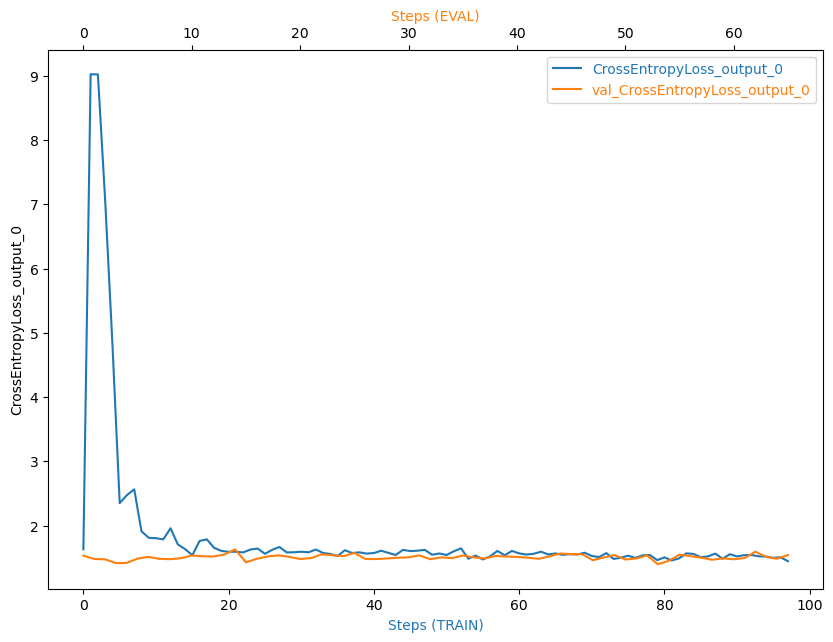

In [8]:
# TODO: Plot a debugging output.
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [9]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(rule_output_path)

s3://sagemaker-us-east-1-063864077654/pytorch-training-2023-12-10-14-53-46-452/rule-output


In [10]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-063864077654/pytorch-training-2023-12-10-14-53-46-452/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-063864077654/pytorch-training-2023-12-10-14-53-46-452/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-063864077654/pytorch-training-2023-12-10-14-53-46-452/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-063864077654/pytorch-training-2023-12-10-14-53-46-452/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-063864077654/pytorch-training-2023-12-10-14-53-46-452/rule-

In [11]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [12]:
# TODO: Display the profiler output
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

### Model Deploying and Querying
**TODO:** Can you deploy your model to an endpoint and then query that endpoint to get a result?

In [13]:
# TODO: Deploy your model to an endpoint
model_location = "s3://sagemaker-us-east-1-063864077654/pytorch-training-2023-12-10-14-53-46-452/output/model.tar.gz"

In [14]:
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [15]:
from sagemaker.pytorch import PyTorchModel

pytorch_model = PyTorchModel(
    model_data=model_location, 
    role=role, 
    entry_point='infer.py',
    py_version='py36',                         
    framework_version='1.8',
    predictor_cls=ImagePredictor
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [16]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.2xlarge')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
----!

In [17]:
# TODO: Run an prediction on the endpoint

import requests
request_dict={ "url": "https://aft-vbi-pds.s3.amazonaws.com/bin-images/523.jpg" }

img_bytes = requests.get(request_dict['url']).content
type(img_bytes)

bytes

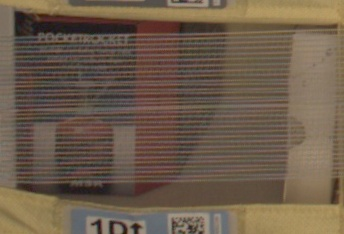

In [18]:
from PIL import Image
import io
Image.open(io.BytesIO(img_bytes))

In [19]:
import numpy as np 

response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})
print(response)

[[-0.8502473831176758, -0.17820237576961517, 0.1913364827632904, 0.17221279442310333, 0.06295153498649597]]


In [20]:
print(f"Predicted class:{np.argmax(response, 1)}")

Predicted class:[2]


In [ ]:
predictor.delete_endpoint()